# Demographic, Economic & Behavioral Data Analysis and Exploration

## Introduction

In this notebook we analyze a few demographic and social factors for the USA, such as:

* Demographics: population, age, income, gender
* Economic: GDP, GDP per Capita, Employment
* Religion

## Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as r
import lxml.html as html
import bs4 as bs
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plt.style.use('ggplot')

import sys
sys.path.append('../../libs/')

import DSF_helpers

init_notebook_mode(connected=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Religion per State

### Reading our Dataset

In [8]:
with open(r'data/religions.html', "r") as f:
    page = f.read()
    
tree = html.fromstring(page)
df_religion = pd.read_html('data/religions.html')[0]

### Basic Data Cleaning

In [9]:
df_religion.columns = ['state', 'percentage'] #Define column names
df_religion['state'] = df_religion.state.str.replace(r'[0-9]+\.', '', regex=True) #Clean state names
df_religion['percentage'] = (df_religion['percentage'].str.replace('%', '')).astype(int) / 100 #Convert into decimal
df_religion['code'] = df_religion.state.str.strip().apply(lambda x: DSF_helpers.state_name_to_abrv(x)) #Create Abbrev

In [10]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale = True,
        locations = df_religion['code'],
        z = df_religion['percentage'].astype(float),
        locationmode = 'USA-states',
        text = df_religion['code'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "% Religious")
        ) ]

layout = dict(
        title = 'USA Percentage of Religious People per State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

<img src="Religion_USA_Plot.png" />

## Comments

* Southeast states are more religious - the so-called **bible-belt**
* We would expect these areas to be Trump supporters
* On the other hand, southwest and northwest are less religious; Northeast is almost non-religious
* Midwest and mideast are mixed

In [11]:
df_religion.to_csv("usa_religion_per_state.csv")

## Education

### Reading our Dataset

In [12]:
df_education = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment', header=0)[0]

In [13]:
df_education.head()

,State,% High school graduate,Rank,% Bachelor's degree,Rank.1,% Advanced degree,Rank.2
0,Tennessee,93.6%,2.0,29.5%,20.0,9.5%,32.0
1,Minnesota,92.4%,2.0,33.7%,10.0,11.2%,17.0
2,New Hampshire,92.3%,3.0,34.9%,8.0,13.0%,9.0
3,Wyoming,92.3%,3.0,25.7%,40.0,8.6%,40.0
4,Alaska,92.1%,5.0,28.0%,26.0,10.1%,27.0


### Basic Cleaning

In [14]:
df_education['code'] = df_education.State.str.strip().apply(lambda x: DSF_helpers.state_name_to_abrv(x))
df_education['% High school graduate'] = (df_education['% High school graduate'].str.replace('%', '')).astype(float) / 100
df_education["% Bachelor's degree"] = (df_education["% Bachelor's degree"].str.replace('%', '')).astype(float) / 100
df_education['% Advanced degree'] = (df_education['% Advanced degree'].str.replace('%', '')).astype(float) / 100

## Visualization

In [60]:
df_education = df_education.sort_values('State')

x = df_education.code
y1 = df_education["% High school graduate"]*100
y2 = df_education["% Bachelor's degree"]*100
y3 = df_education['% Advanced degree']*100

trace1 = {
    'x': x,
    'y': y1,
    'name': '% High School Graduate',
    'type': 'bar',
}

trace2 = {
    'x': x,
    'y': y2,
    'name': "% Bachelor's Degree",
    'type': 'bar',
}

trace3 = {
    'x': x,
    'y': y3,
    'name': "% Advanced Degree",
    'type': 'bar',
    'text': y3,
    'textposition': 'inside',
    'textfont': {
        'size': 9}
}



data = [trace1, trace2, trace3];
layout = {
    'xaxis': {'tickfont': {
                'size':8}
             },
    'yaxis': {'title': 'Y axis'},
    'barmode': 'relative',
    'title': 'High School, Bachelor Degree and Advance Degree by State',

};

iplot({'data': data, 'layout': layout}, filename='barmode-relative')

<img src='Stacked.png'/>

## Comments

* High school levels are mostly homogeneous across the country
* Bachelor's and Advanced Degrees is more dispersed across the states
* We would expect some correlation between education and religion

## Analyzing Education vs. Religion

In [17]:
df_merged = pd.merge(left=df_religion, right=df_education, on='code').dropna()

In [18]:
df_merged.loc[:,['percentage', '% High school graduate', "%Bachelor's degree", "% Advanced degree"]].corr()

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



,percentage,% High school graduate,%Bachelor's degree,% Advanced degree
percentage,1.000000,-0.500293,NaN,-0.537939
% High school graduate,-0.500293,1.000000,NaN,0.225271
%Bachelor's degree,NaN,NaN,NaN,NaN
% Advanced degree,-0.537939,0.225271,NaN,1.000000


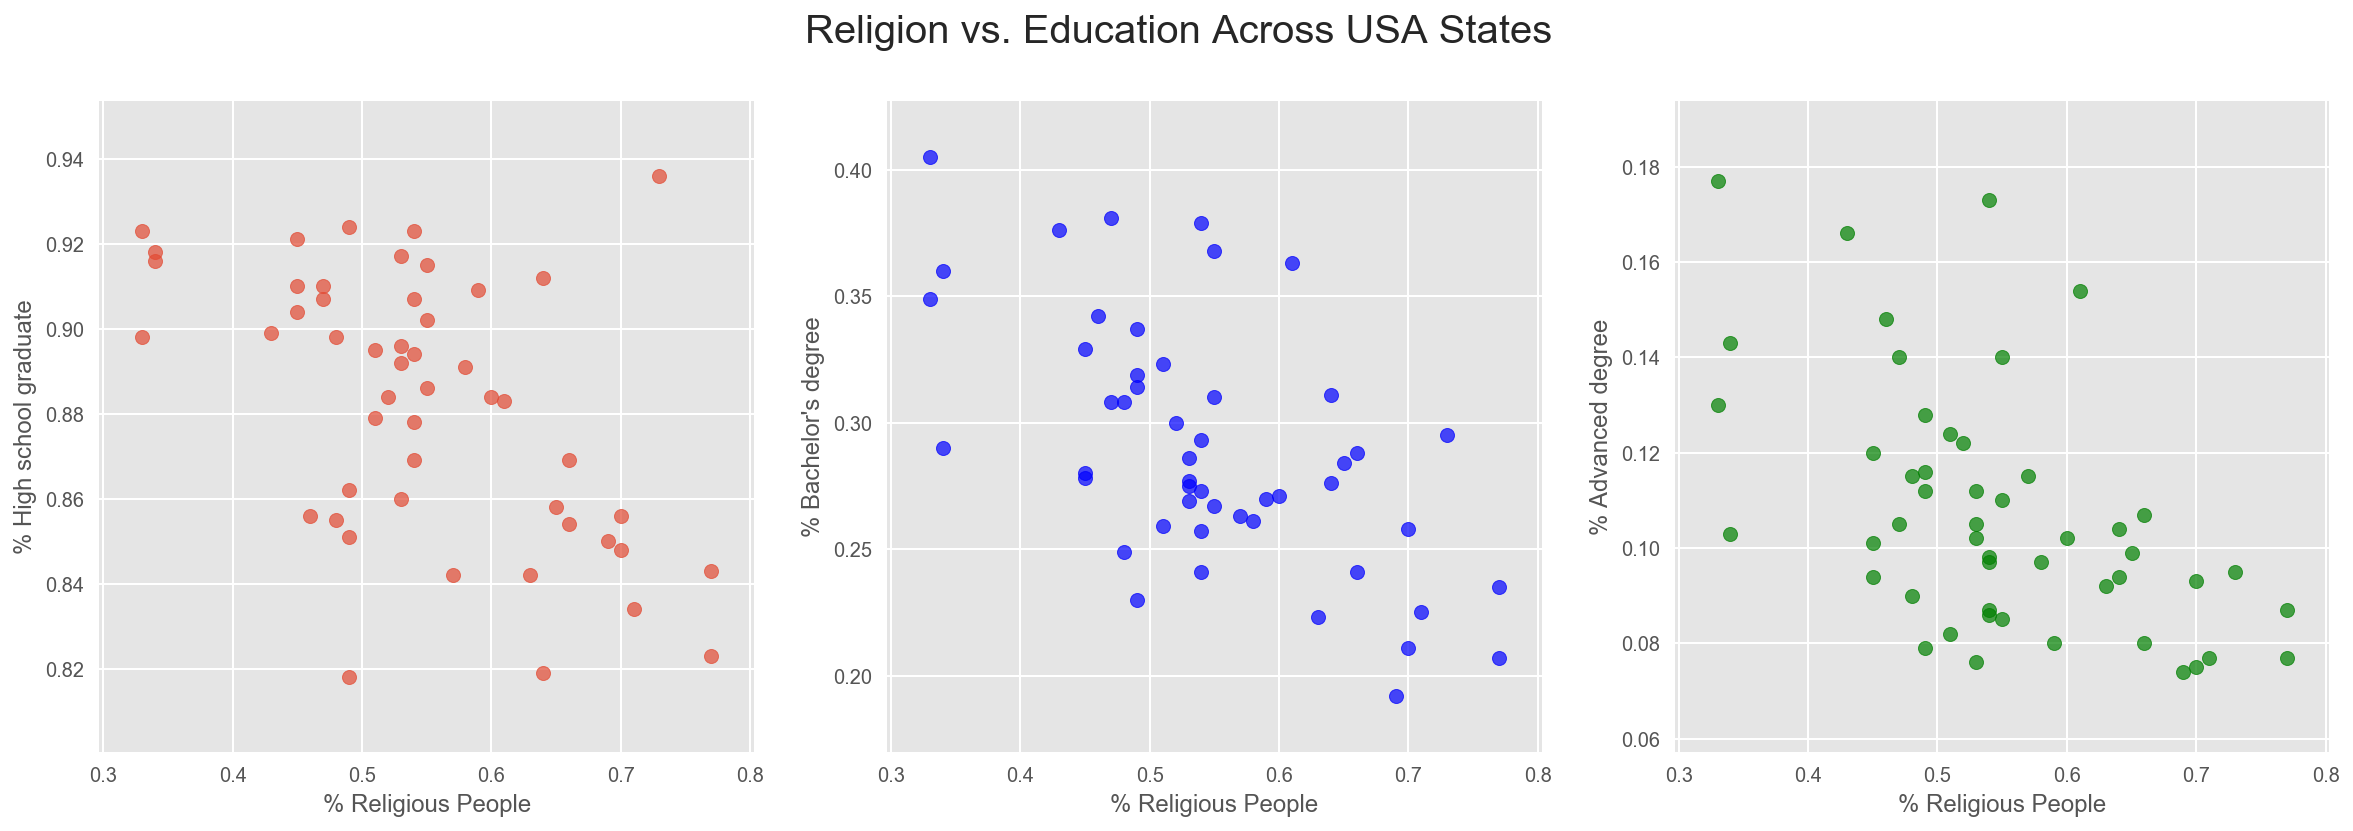

In [19]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

fig.suptitle('Religion vs. Education Across USA States', fontsize=20)

ax[0].scatter(df_merged.percentage, df_merged["% High school graduate"], alpha=0.7)
ax[1].scatter(df_merged.percentage, df_merged["% Bachelor's degree"], alpha=0.7, color='blue')
ax[2].scatter(df_merged.percentage, df_merged["% Advanced degree"], alpha=0.7, color='green')

ax[0].set_xlabel("% Religious People")
ax[1].set_xlabel("% Religious People")
ax[2].set_xlabel("% Religious People")

ax[0].set_ylabel("% High school graduate")
ax[1].set_ylabel("% Bachelor's degree")
ax[2].set_ylabel("% Advanced degree")

In [20]:
df_merged = df_merged.rename(columns={'percentage': 'percentage_religious'})

In [21]:
df_merged.to_csv('dataset_religion_education.csv')

## Unemployment

In [5]:
import requests
import json

url = 'https://data.bls.gov/timeseries/LASST{0}0000000000003'
xpath_state = '//*[@id="bodytext"]/table[2]/caption/pre/text()[3]'

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['LASST010000000000003'],"startyear":"2016", "endyear":"2017"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)

In [6]:
json_data['Results']

{'series': [{'data': [{'footnotes': [{}],
     'period': 'M12',
     'periodName': 'December',
     'value': '3.8',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M11',
     'periodName': 'November',
     'value': '3.8',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M10',
     'periodName': 'October',
     'value': '3.8',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M09',
     'periodName': 'September',
     'value': '3.9',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M08',
     'periodName': 'August',
     'value': '4.0',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M07',
     'periodName': 'July',
     'value': '4.1',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M06',
     'periodName': 'June',
     'value': '4.3',
     'year': '2017'},
    {'footnotes': [{}],
     'period': 'M05',
     'periodName': 'May',
     'value': '4.6',
     'year': '2017'},
    {'footnotes': [{}],
     'period'